In [8]:
import dataclasses
import functools

import jax
from jax import numpy as jnp
import numpy as np

from flax import linen
from flax import struct
import optax
from tensorflow_probability.substrates import jax as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

import gym
from matplotlib import pylab as plt

import daves_rl_lib
from daves_rl_lib import networks
from daves_rl_lib.algorithms import deep_q_network
from daves_rl_lib.environments import environment_lib
from daves_rl_lib.environments import gym_environment
from daves_rl_lib.internal import video_util

video_util.initialize_virtual_display()

Display already initialized; doing nothing.


In [2]:
env_name = 'CartPole-v1'  # 'MountainCar-v0'
buffer_size = 2048
epsilon = optax.exponential_decay(
    init_value=0.9,
    transition_steps=10000 if 'MountainCar' in env_name else 2000,
    decay_rate=0.1,
    end_value=1e-3)
discount_factor = 0.999
learning_rate = optax.piecewise_constant_schedule(
    init_value=0.01,
    boundaries_and_scales={2000: 0.5, 5000: 0.5, 10000: 0.5, 15000: 0.5})
gradient_batch_size = 32
target_weights_decay = 0.99

In [3]:
env = gym_environment.GymEnvironment(
    gym.make(env_name),
    discount_factor=discount_factor)


In [4]:
agent = deep_q_network.DQNAgent(
    qvalue_net=networks.make_model([24, 24, env.action_space.num_actions],
                                   obs_size=env.observation_size),
    qvalue_optimizer=optax.adam(learning_rate),
    replay_buffer_size=buffer_size,
    target_weights_decay=target_weights_decay,
    gradient_batch_size=gradient_batch_size,
    discount_factor=discount_factor,
    epsilon=epsilon)

In [5]:
seed = jax.random.PRNGKey(0)
seed, weights_init_seed, state_init_seed = jax.random.split(seed, 3)

state = env.reset(seed=state_init_seed)
initial_state_observation = state.observation

weights = agent.init_weights(seed=weights_init_seed,
                             dummy_observation=state.observation,
                             dummy_action=env.action_space.dummy_action())

In [6]:
import time

select_action = jax.jit(
    lambda w, obs, s: agent.action_dist(w, obs).sample(seed=s))
update = jax.jit(agent.update)

In [9]:

durations = []
returns = []

for episode in range(100):
    seed, state_init_seed = jax.random.split(seed, 2)
    state = env.reset(seed=state_init_seed)
    t0 = time.time()
    num_steps = 0
    while not state.done:
        seed, action_seed, env_seed = jax.random.split(seed, 3)
        action = select_action(weights, state.observation, action_seed)
        next_state = env.step(action)
        weights = update(weights,
                         transition=environment_lib.Transition(
                            observation=state.observation,
                            action=action,
                            next_observation=next_state.observation,
                            reward=next_state.reward,
                            done=next_state.done)
                        )
        state = next_state
        num_steps += 1
    print(f"Finished episode {episode} of length {num_steps} in {time.time() - t0 : .2f}s with return {state.episode_return}.")
    durations.append(num_steps)
    returns.append(state.episode_return)


Finished episode 0 of length 18 in  2.83s with return 17.847814559936523.
Finished episode 1 of length 26 in  0.49s with return 25.677589416503906.
Finished episode 2 of length 22 in  0.11s with return 21.770536422729492.
Finished episode 3 of length 13 in  0.06s with return 12.922286033630371.
Finished episode 4 of length 17 in  0.10s with return 16.86467933654785.
Finished episode 5 of length 22 in  0.10s with return 21.770536422729492.
Finished episode 6 of length 15 in  0.07s with return 14.895454406738281.
Finished episode 7 of length 24 in  0.13s with return 23.726016998291016.
Finished episode 8 of length 15 in  0.07s with return 14.895454406738281.
Finished episode 9 of length 16 in  0.08s with return 15.880558967590332.
Finished episode 10 of length 20 in  0.11s with return 19.811138153076172.
Finished episode 11 of length 11 in  0.06s with return 10.945165634155273.
Finished episode 12 of length 22 in  0.10s with return 21.770536422729492.
Finished episode 13 of length 26 in 

Text(0.5, 1.0, 'Episode durations')

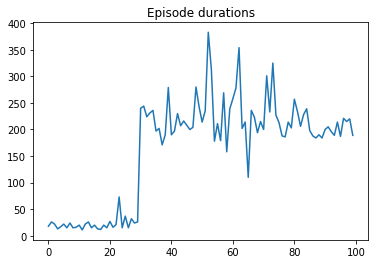

In [10]:
plt.plot(durations)
plt.title('Episode durations')

In [11]:
print("Estimated value", agent._qvalue_net.apply(weights.qvalue_weights, initial_state_observation))


Estimated value [153.9123  156.17055]


In [47]:
images = []
# Collect frames to visualize.
for step in range(512):
    learner = step_learner(learner)
    images.append(env._gym_env.render(mode="rgb_array"))

In [48]:
video_util.display_frames(images, frames_per_second=15)